## N = 9

### Set up Dataloader

In [ ]:
import numpy as np

# load date
X = np.load("Datasets/kryptonite-9-X.npy")
X.shape

(18000, 9)

In [ ]:
y = np.load("Datasets/kryptonite-9-y.npy")
y.shape

(18000,)

In [4]:
import numpy as np
import torch
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Step 1: Apply GMM Transformation to each feature in X
X_gmm = np.zeros_like(X)

for i in range(X.shape[1]):
    # Fit GMM with 2 components for each feature
    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(X[:, i].reshape(-1, 1))
    X_gmm[:, i] = gmm.predict(X[:, i].reshape(-1, 1))

# Step 2: Combine the original features with the GMM-labeled features
X_combined = np.concatenate([X, X_gmm], axis=1)

# Convert numpy arrays to PyTorch tensors
# put input to X_combine if using preprocessing

X_tensor = torch.tensor(X, dtype=torch.float)
y_tensor = torch.tensor(y, dtype=torch.float)
# create a TensorDataset
dataset = TensorDataset(X_tensor, y_tensor)

# define split sizes (90% train, 10% validation)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
# Split the dataset into train and validation
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


### Set Up Model

In [5]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# build model for training
class MLP(nn.Module):
    def __init__(self, input_size=9, hidden_size=128, output_size=1):
        super(MLP, self).__init__()

        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size*2)
        self.layer3 = nn.Linear(hidden_size*2, hidden_size*2)
        self.layer4 = nn.Linear(hidden_size*2, hidden_size)
        self.layer5 = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = torch.sigmoid(self.layer5(x))  # sigmoid activation for binary output
        return x


### Train

In [6]:
def train(model, train_loader, test_loader, loss_fn, optimizer, scheduler):
    # set the number of epochs
    epochs = 50
    best_acc = 0

    for epoch in range(epochs):
        """ Training """
        model.train()

        # forward pass
        correct = 0
        total = 0
        train_loss = 0
        for X_batch, y_batch in train_loader:
            output = model(X_batch).squeeze()
            y_preds = torch.round(output)

            correct += torch.eq(y_preds, y_batch).sum().item()
            total += len(y_batch)

            loss = loss_fn(output, y_batch)
            train_loss += loss.item()
            # zero the optimizer
            optimizer.zero_grad()
            # backpropagattion
            loss.backward()
            # GD
            optimizer.step()

        scheduler.step()
        train_acc = (correct / total) * 100

        """ Testing """
        model.eval()
        correct = 0
        total = 0
        test_loss = 0
        fold_outputs = []
        fold_labels = []
        with torch.inference_mode():
            for X_batch, y_batch in test_loader:
                output = model(X_batch).squeeze()

                # for calibration analysis
                fold_outputs.extend(output.cpu().numpy())
                fold_labels.extend(y_batch.cpu().numpy())

                y_preds = torch.round(output)

                correct += torch.eq(y_preds, y_batch).sum().item()
                total += len(y_batch)

                loss = loss_fn(output, y_batch)
                test_loss += loss.item()

            test_acc = (correct / total) * 100
            if test_acc > best_acc:
                best_acc = test_acc
                torch.save(model.state_dict(), "n-9best.pth")

        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f} | Acc: {train_acc:.2f}% | Learning Rate: {scheduler.get_last_lr()[0]:.7f} | Val loss: {test_loss:.5f} | Val Acc: {test_acc:.2f}%")


    return best_acc,  fold_outputs, fold_labels

def plot_calibration_curve(y_true, y_prob):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)

    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label="Calibration Curve")
    plt.plot([0, 1], [0, 1], linestyle='--', label="Perfectly Calibrated")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Calibration Curve")
    plt.legend()
    plt.show()

In [7]:
# Set up 8-fold cross-validation on the training dataset
kf = KFold(n_splits=8, shuffle=True)
train_indices = list(range(len(train_dataset)))
batch = 128
accuracy = []

all_outputs = []
all_labels = []

# Generate train-test splits
for fold, (train_idx, test_idx) in enumerate(kf.split(train_indices)):
    print("\n\nFold:", fold)
    """ create dataloaders for each fold """
    train_subset = Subset(train_dataset, train_idx)
    test_subset = Subset(train_dataset, test_idx)
    # Creating data loaders for each fold
    train_loader = DataLoader(train_subset, batch_size=batch, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=batch, shuffle=False)

    """ initialize the model, loss function, and optimizer """
    model = MLP(input_size=X_tensor.shape[1], hidden_size=128, output_size=1)
    loss_fn = nn.BCELoss()  # binary Cross-Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

    """ train and test the model """
    acc, fold_outputs,fold_labels = train(model, train_loader, test_loader, loss_fn, optimizer, scheduler)
    accuracy.append(acc)
    all_outputs.extend(fold_outputs)  # Collect outputs from all folds
    all_labels.extend(fold_labels)    # Collect labels from all folds


print("\nAverage Accuracy is:", np.mean(accuracy))





Fold: 0
Epoch: 0 | Train Loss: 76.93935 | Acc: 50.46% | Learning Rate: 0.0001000 | Val loss: 11.09040 | Val Acc: 50.17%
Epoch: 10 | Train Loss: 20.01646 | Acc: 95.80% | Learning Rate: 0.0001000 | Val loss: 3.41508 | Val Acc: 95.01%
Epoch: 20 | Train Loss: 17.63819 | Acc: 95.86% | Learning Rate: 0.0000100 | Val loss: 3.28503 | Val Acc: 95.01%
Epoch: 30 | Train Loss: 17.35400 | Acc: 95.85% | Learning Rate: 0.0000100 | Val loss: 3.29492 | Val Acc: 95.06%
Epoch: 40 | Train Loss: 17.16440 | Acc: 95.85% | Learning Rate: 0.0000010 | Val loss: 3.32597 | Val Acc: 94.91%


Fold: 1
Epoch: 0 | Train Loss: 76.93569 | Acc: 50.73% | Learning Rate: 0.0001000 | Val loss: 11.08282 | Val Acc: 50.02%
Epoch: 10 | Train Loss: 21.32433 | Acc: 95.46% | Learning Rate: 0.0001000 | Val loss: 3.06226 | Val Acc: 95.65%
Epoch: 20 | Train Loss: 18.83020 | Acc: 95.67% | Learning Rate: 0.0000100 | Val loss: 2.84302 | Val Acc: 95.75%
Epoch: 30 | Train Loss: 18.59646 | Acc: 95.68% | Learning Rate: 0.0000100 | Val loss

In [8]:
# Function to compute ECE
def compute_ece(y_true, y_prob, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    bin_errors = []  # To store errors for plotting

    for i in range(n_bins):
        bin_lower = bin_boundaries[i]
        bin_upper = bin_boundaries[i + 1]
        bin_mask = (y_prob >= bin_lower) & (y_prob < bin_upper)
        bin_size = np.sum(bin_mask)

        if bin_size > 0:
            avg_pred_prob = np.mean(y_prob[bin_mask])
            fraction_positives = np.mean(y_true[bin_mask])
            error = np.abs(avg_pred_prob - fraction_positives)
            ece += (bin_size / len(y_true)) * error
            bin_errors.append(error)
        else:
            bin_errors.append(0.0)

    return ece, bin_errors

# Compute ECE and get bin errors
ece, bin_errors = compute_ece(np.array(all_labels), np.array(all_outputs))
print("\nAverage Accuracy is:", np.mean(accuracy))
print(f"Expected Calibration Error (ECE): {ece:.4f}")


Average Accuracy is: 95.74691358024691
Expected Calibration Error (ECE): 0.0137


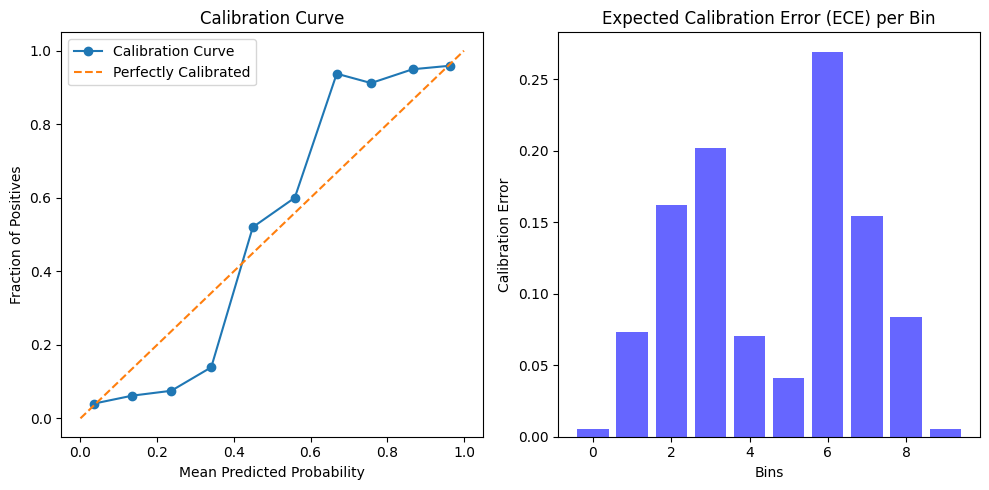

In [11]:
# Plot Calibration Curve and ECE
def plot_calibration_and_ece(y_true, y_prob, bin_errors, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)

    # Plot calibration curve
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(prob_pred, prob_true, marker='o', label="Calibration Curve")
    plt.plot([0, 1], [0, 1], linestyle='--', label="Perfectly Calibrated")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Calibration Curve")
    plt.legend()

    # Plot ECE as a bar plot
    plt.subplot(1, 2, 2)
    plt.bar(range(n_bins), bin_errors, width=0.8, color='blue', alpha=0.6)
    plt.xlabel("Bins")
    plt.ylabel("Calibration Error")
    plt.title("Expected Calibration Error (ECE) per Bin")
    plt.tight_layout()
    plt.show()
# Plot calibration curve
plot_calibration_and_ece(np.array(all_labels), np.array(all_outputs), bin_errors)


### Evaluation

In [ ]:
model = MLP(input_size=9, hidden_size=128, output_size=1)
model.load_state_dict(torch.load("n-9best.pth"))
model.eval()

val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

correct = 0
total = 0
val_loss = 0
with torch.inference_mode():
    for X_batch, y_batch in tqdm(val_loader):
        output = model(X_batch).squeeze()
        y_preds = torch.round(output)

        correct += torch.eq(y_preds, y_batch).sum().item()
        total += len(y_batch)

        loss = loss_fn(output, y_batch)
        val_loss += loss.item()

    val_acc = (correct / total) * 100

print(f"Test Loss: {val_loss:.5f} | Test Acc: {val_acc:.2f}%")

<ipython-input-18-4f430b98a633>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("n-9best.pth"))
100%|██████████| 15/15 [00:00<00:00, 724.84

Test Loss: 2.89696 | Test Acc: 95.56%
